In [2]:
import Pkg

Pkg.activate("Project.toml")

using CUDA
using Statistics
using Random
using Test
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take
using Plots; default(fmt=:png,ls=:auto)

import Knet
using Knet: deconv4, conv4, unpool, pool, mat, sigm, KnetArray, nll, zeroone, progress, adam!, sgd!, param, param0, dropout, relu, minibatch, Data
import Knet: train!

using MLDatasets: MNIST

 Activating environment at `~/Desktop/MSc/repos/yolo-julia/Project.toml`


In [132]:
# Load data
xtrn, ytrn = MNIST.traindata(Float32); ytrn[ytrn.==0] .= 10;
xtst, ytst = MNIST.testdata(Float32);  ytst[ytst.==0] .= 10;

In [3]:
include("nn.jl")

import .NN

dtrn = minibatch(xtrn, ytrn, 2; xsize = (28,28,1,:), xtype=Knet.atype(), shuffle=true);
dtst = minibatch(xtst, ytst, 2; xsize = (28,28,1,:), xtype=Knet.atype());
x, y = first(dtst)


dl2 = NN.Conv2d(5, 1, 1)
println(size(dl2.w))
cc = NN.Chain()
println(typeof(cc))
push!(cc.layers, dl2)
cc.layers

(5, 5, 1, 1)
Main.NN.Chain


1-element Array{Any,1}:
 Main.NN.Conv2d(P(Array{Float32,4}(5,5,1,1)), nothing, 1, 0)

In [129]:
include("utils/parse_config.jl")
include("models.jl")

# mdefs = parse_model_cfg("yolov3.cfg")
# module_list, routes = create_modules(mdefs, 416);
x = convert(Knet.atype(), randn(416,416,3,2))
y = [1,2]

size(x)[1:2]
darknet = Darknet("yolov3.cfg")
darknet(x; verbose=true)

yolo
yolo


yolo
0 (416, 416, 3, 2)
1 /107 Main.NN.Chain (416, 416, 32, 2)
2 /107 Main.NN.Chain (208, 208, 64, 2)
3 /107 Main.NN.Chain (208, 208, 32, 2)
4 /107 Main.NN.Chain (208, 208, 64, 2)
[-2] [2]
5 /107 Main.NN.WeightedFeatureFusion (208, 208, 64, 2)
6 /107 Main.NN.Chain (104, 104, 128, 2)
7 /107 Main.NN.Chain (104, 104, 64, 2)
8 /107 Main.NN.Chain (104, 104, 128, 2)
[-2] [6]
9 /107 Main.NN.WeightedFeatureFusion (104, 104, 128, 2)
10 /107 Main.NN.Chain (104, 104, 64, 2)
11 /107 Main.NN.Chain (104, 104, 128, 2)
[-2] [9]
12 /107 Main.NN.WeightedFeatureFusion (104, 104, 128, 2)
13 /107 Main.NN.Chain (52, 52, 256, 2)
14 /107 Main.NN.Chain (52, 52, 128, 2)
15 /107 Main.NN.Chain (52, 52, 256, 2)
[-2] [13]
16 /107 Main.NN.WeightedFeatureFusion (52, 52, 256, 2)
17 /107 Main.NN.Chain (52, 52, 128, 2)
18 /107 Main.NN.Chain (52, 52, 256, 2)
[-2] [16]
19 /107 Main.NN.WeightedFeatureFusion (52, 52, 256, 2)
20 /107 Main.NN.Chain (52, 52, 128, 2)
21 /107 Main.NN.Chain (52, 52, 256, 2)
[-2] [19]
22 /107 Main

In [46]:
nn = enumerate(darknet.module_list)

x, y = first(nn)

isa(darknet.module_list[87], NN.FeatureConcat)

true

In [127]:
a = ones(26,26,512,16)
b = ones(26,26,512,16)
c = ones(26,26,512,16)
ab = [a,b]
l = [2, 1]
y = sum(ab[l], dims=4)
size(y)
ab[l]
y

2-element Array{Array{Float64,4},1}:
 [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]

[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]

[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]

...

[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]

[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]

[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]

[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]

[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]

[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]

...

[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]

[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0]

[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0

In [71]:
include("nn.jl")

import .NN

In [72]:
function dtype(); CUDA.functional() ? KnetArray{Float32} : Array{Float32}; end;

# Define dense layer:
struct Dense
    w; b; f; p; 
    
    function Dense(inputsize::Int, outputsize::Int, f=relu; 
            pdrop=0, atype=dtype())
        
        return new(
            param(outputsize, inputsize; atype=atype),
            param0(outputsize; atype=atype),
            f,
            pdrop
        )
    end
end

(d::Dense)(x) = d.f.(d.w * mat(dropout(x, d.p)) .+ d.b)


# Define convolutional layer:
struct Conv 
    w; b; f; p; 
    
    function Conv(w1::Int, w2::Int, cx::Int, cy::Int, f=relu;
            pdrop=0, atype=dtype())
        
        return new(
            param(w1,w2,cx,cy; atype=atype), 
            param0(1,1,cy,1; atype=atype),
            f,
            pdrop
        )
    end
end

(c::Conv)(x) = c.f.(conv4(c.w, dropout(x, c.p)) .+ c.b)


# Define chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end

(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)  # Forward pass

# Loss and accuracy
function (c::Chain)(x, y; accuracy::Bool=false)
    y_pred = c(x)
    
    if accuracy
        correct = 0.0
        
        for i=1:length(y)
            correct += y[i] == findmax(y_pred[:, i]; dims=1)[2][1] ? 1.0 : 0.0
        end
        
        return correct / length(y)
    else
        return nll(y_pred, y)
    end
end

(c::Chain)(d::Data; accuracy::Bool=false) = mean(c(x,y; accuracy=accuracy) for (x,y) in d)  # Batch loss

In [74]:
# Load data
xtrn, ytrn = MNIST.traindata(Float32); ytrn[ytrn.==0] .= 10;
xtst, ytst = MNIST.testdata(Float32);  ytst[ytst.==0] .= 10;
xtrn = reshape(xtrn, (28, 28, 1, :))
xtrn = xtrn[:,:,:,1:250]
xtrn = unpool(xtrn; stride=14)
xtst = reshape(xtst, (28, 28, 1, :))
xtst = xtst[:,:,:,1:50]
xtst = unpool(xtst; stride=14)
dtrn = minibatch(xtrn, ytrn[1:250], 4; xsize = (380,380,1,:), xtype=Knet.atype(), shuffle=true);
dtst = minibatch(xtst, ytst[1:50], 4; xsize = (380,380,1,:), xtype=Knet.atype());

include("utils/parse_config.jl")
include("models.jl")

darknet = Darknet("mnist.cfg"; verbose=true);


yolo


yolo
yolo


In [5]:
include("nn.jl")

import .NN

function train!(model::NN.Chain, train_data::Data, test_data::Data;
                  period::Int=4, iters::Int=100, lr=0.15, optimizer=sgd!)  # or optimizer=adam!
    
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    
    for i in 0:period:iters
        push!(train_loss, model(train_data))
        push!(test_loss, model(test_data))
    
        push!(train_acc, model(train_data; accuracy=true))
        push!(test_acc, model(test_data; accuracy=true))
        
        optimizer(model, take(cycle(train_data), period); lr=lr)
        
        
            println("Iter: ", i)
    end
    
    return 0:period:iters, train_loss, train_acc, test_loss, test_acc
end

train! (generic function with 2 methods)

Iter: 0
Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9
Iter: 10
Iter: 11
Iter: 12
Iter: 13
Iter: 14
Iter: 15
Iter: 16
Train loss: 1.48, Best train accuracy: 0.65

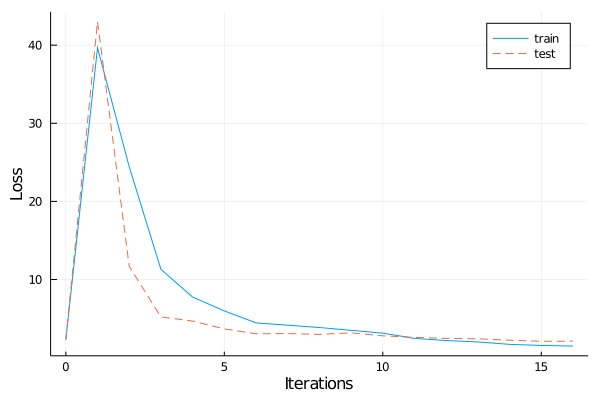

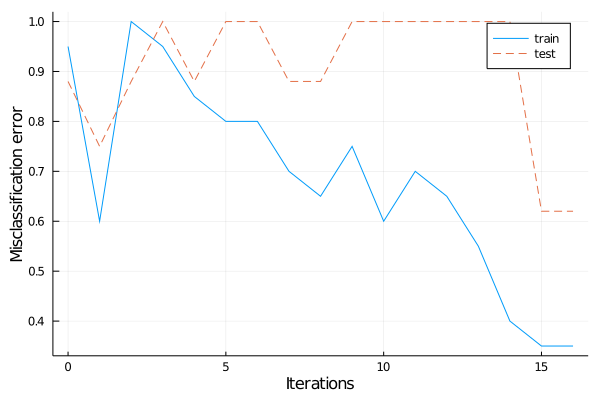


Test loss: 2.11, Best test accuracy: 0.38


In [6]:


Random.seed!(1)

model = NN.Chain(
    NN.Conv2d(1, 1, 5),
    NN.LeakyReLU(),
    NN.Upsample2d(2),
    NN.Dense(2888000,10,identity),
)


model = NN.Chain(
    darknet,
    NN.Dense(587520,10,identity)
)

xtrn, ytrn = MNIST.traindata(Float32); ytrn[ytrn.==0] .= 10;
xtst, ytst = MNIST.testdata(Float32);  ytst[ytst.==0] .= 10;
xtrn = reshape(xtrn, (28, 28, 1, :))
xtrn = xtrn[:,:,:,1:20]
xtrn = unpool(xtrn; stride=14)
xtst = reshape(xtst, (28, 28, 1, :))
xtst = xtst[:,:,:,1:8]
xtst = unpool(xtst; stride=14)
dtrn = minibatch(xtrn, ytrn[1:20], 4; xsize = (380,380,1,:), xtype=Knet.atype(), shuffle=true);
dtst = minibatch(xtst, ytst[1:8], 4; xsize = (380,380,1,:), xtype=Knet.atype());


iters, trnloss, trnacc, tstloss, tstacc = train!(
    model, dtrn, dtst; 
    period=1, iters=16, lr=0.15, optimizer=sgd!);

# @time train!(
#     model, dtrn, dtst; 
#     period=1, iters=10, lr=0.15, optimizer=sgd!);

println("Train loss: $(round(trnloss[end], digits=2)), Best train accuracy: $(ceil(maximum(trnacc), digits=2))")
println("Test loss: $(round(tstloss[end], digits=2)), Best test accuracy: $(ceil(maximum(tstacc), digits=2))")

plot(iters, trnloss, label="train", xlabel="Iterations", ylabel="Loss")
display(plot!(iters, tstloss, label="test"))

plot(iters, round.(1 .- trnacc, digits=2), label="train", xlabel="Iterations", ylabel="Misclassification error")
display(plot!(iters, round.(1 .- tstacc, digits=2), label="test"))

In [90]:
ytst[1:20]

20-element Array{Int64,1}:
  7
  2
  1
 10
  4
  1
  4
  9
  5
  9
 10
  6
  9
 10
  1
  5
  9
  7
  3
  4

In [81]:
xx = convert(Knet.atype(), reshape(1:36, (6, 6, 1, 1)))
# y = dl2(xx)

6×6×1×1 Array{Float32,4}:
[:, :, 1, 1] =
 1.0   7.0  13.0  19.0  25.0  31.0
 2.0   8.0  14.0  20.0  26.0  32.0
 3.0   9.0  15.0  21.0  27.0  33.0
 4.0  10.0  16.0  22.0  28.0  34.0
 5.0  11.0  17.0  23.0  29.0  35.0
 6.0  12.0  18.0  24.0  30.0  36.0

In [79]:
unpool(xx; window=4)

24×24×1×1 Array{Float32,4}:
[:, :, 1, 1] =
 1.0  1.0  1.0  1.0   7.0   7.0   7.0  …  25.0  25.0  31.0  31.0  31.0  31.0
 1.0  1.0  1.0  1.0   7.0   7.0   7.0     25.0  25.0  31.0  31.0  31.0  31.0
 1.0  1.0  1.0  1.0   7.0   7.0   7.0     25.0  25.0  31.0  31.0  31.0  31.0
 1.0  1.0  1.0  1.0   7.0   7.0   7.0     25.0  25.0  31.0  31.0  31.0  31.0
 2.0  2.0  2.0  2.0   8.0   8.0   8.0     26.0  26.0  32.0  32.0  32.0  32.0
 2.0  2.0  2.0  2.0   8.0   8.0   8.0  …  26.0  26.0  32.0  32.0  32.0  32.0
 2.0  2.0  2.0  2.0   8.0   8.0   8.0     26.0  26.0  32.0  32.0  32.0  32.0
 2.0  2.0  2.0  2.0   8.0   8.0   8.0     26.0  26.0  32.0  32.0  32.0  32.0
 3.0  3.0  3.0  3.0   9.0   9.0   9.0     27.0  27.0  33.0  33.0  33.0  33.0
 3.0  3.0  3.0  3.0   9.0   9.0   9.0     27.0  27.0  33.0  33.0  33.0  33.0
 3.0  3.0  3.0  3.0   9.0   9.0   9.0  …  27.0  27.0  33.0  33.0  33.0  33.0
 3.0  3.0  3.0  3.0   9.0   9.0   9.0     27.0  27.0  33.0  33.0  33.0  33.0
 4.0  4.0  4.0  4.0  10.0  10.0  